In [74]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random
from datetime import time
from sklearn import svm
%matplotlib inline

random.seed(100)

datadir = './data/'

data_raw = pd.read_csv(datadir + 'USvideos.csv')

# Preprocessing

Convert times to date

In [75]:
data_raw['publish_time'] = pd.to_datetime(data_raw.publish_time)

Convert the publish time to which day of the week it was published on

In [76]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_raw['trending_date'] = '20' + data_raw['trending_date'] 
data_raw['trending_date'] = pd.to_datetime(data_raw.trending_date, format='%Y.%d.%m').dt.dayofweek
data_raw['trending_date'] = data_raw['trending_date'].apply(lambda x: weekday_labels[int(x)])

In [77]:
data_raw.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,Tuesday,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,Tuesday,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,Tuesday,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,Tuesday,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,Tuesday,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


Convert the video category ids to actual readable text

Our tidy data will be in a variable named tidy. We removed ratings, comments, thumbnail_link from out columns. After that, we will start  by binning the publish_time column into Late-night (12am-7am), morning(7am-11am), noon(11am-12pm), afternoon (12pm-7pm), Night(7pm-12am

In [78]:
tidy = data_raw.copy(deep=True)
del tidy['ratings_disabled']
del tidy['comments_disabled']
del tidy['thumbnail_link']
del tidy['video_error_or_removed']

In [79]:
periods = {'Morning(5a-11a)': [time(5), time(11)], 'Noon(11a-12p)': [time(11), time(12)], 
           'Afternoon(12p-7p)': [time(12), time(19)],
          'Night(7p-12a)': [time(19), time(23)], 'Overnight(12a-5a)': [time(0), time(5)]}

In [80]:
def bin_values(x, labels=periods):
    for k, v in labels.items():
        if x.hour >= v[0].hour and x.hour < v[1].hour:
            return k
    return 'Unknown_period'
            

In [81]:
tidy['publish_time'] = tidy['publish_time'].apply(bin_values)

We will update the video categories with their representative name

In [82]:
video_categories = pd.read_csv(datadir + 'youtube_video_categories.csv', names=['id', 'title'])

In [83]:
video_categories.head()

,id,title
0,2,Autos & Vehicles
1,1,Film & Animation
2,10,Music
3,15,Pets & Animals
4,17,Sports


In [84]:
for index, video_id in enumerate(tidy['category_id']):
    cat = video_categories[ video_categories['id'] == video_id]['title'].iloc[0]
    tidy['category_id'][index] = cat

/home/anderson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anderson/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [85]:
tidy.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description
0,2kyS6SvSYSE,Tuesday,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,Afternoon(12p-7p),SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,Tuesday,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,Morning(5a-11a),"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,"One year after the presidential election, John..."
2,5qpjK5DgCt4,Tuesday,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,Night(7p-12a),"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,Tuesday,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,Noon(11a-12p),"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,Tuesday,I Dare You: GOING BALD!?,nigahiga,Entertainment,Afternoon(12p-7p),"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,I know it's been a while since we did this sho...


# Exploratory analysis

Let's analyze the correlation between the variables

In [86]:
tidy.corr()

,views,likes,dislikes,comment_count
views,1.000000,0.862345,0.877074,0.576112
likes,0.862345,1.000000,0.785976,0.825322
dislikes,0.877074,0.785976,1.000000,0.573135
comment_count,0.576112,0.825322,0.573135,1.000000


We can see that there is high correlation between views, likes, dislikes, and comment_count. Same for the comment_count-views vs views-dislikes Let's apply a t-test and look at the p-values to check if these correlation values are meaningful.

In [87]:
print(scipy.stats.ttest_ind(tidy.views, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.likes, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.dislikes, tidy.comment_count))
print(scipy.stats.ttest_ind(tidy.likes, tidy.views))
print(scipy.stats.ttest_ind(tidy.dislikes, tidy.views))

Ttest_indResult(statistic=14.612476613251605, pvalue=1.7357111023995378e-47)
Ttest_indResult(statistic=13.173163447349744, pvalue=4.7490090179999976e-39)
Ttest_indResult(statistic=-8.269136924405986, pvalue=1.6698876066463316e-16)
Ttest_indResult(statistic=-14.115697145703365, pvalue=1.7484866955743467e-44)
Ttest_indResult(statistic=-14.649713898263149, pvalue=1.0245296499564799e-47)


We can see the p-values are well below 0.05 which indicates they are significant. Below is a plot of the distrubutions between the correlated variables

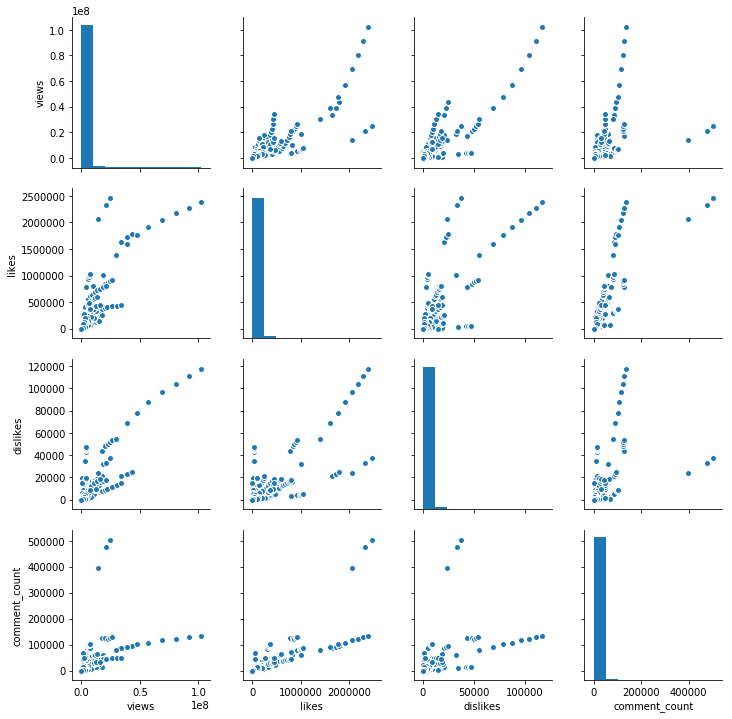

In [88]:
sns.pairplot(tidy[['views', 'likes', 'dislikes', 'comment_count']])

## Outlier Detection

Let's use a basic linear model to see if we can detected outliers

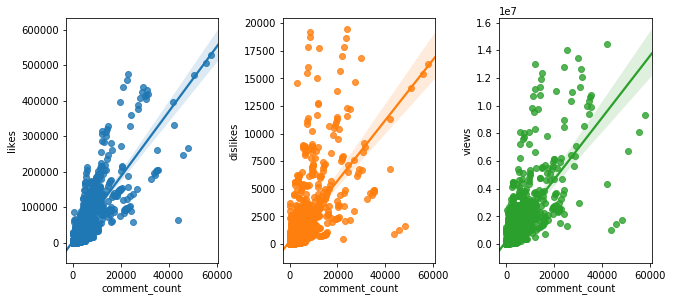

In [102]:
fig, ax = plt.subplots(1, 3)
fig.tight_layout()
plt.subplots_adjust(left=-0.4)
lplot = sns.regplot(data=tidy, x='comment_count', y='likes', ax=ax[0])
#lplot.set(xticks=[])
lplot2 = sns.regplot(data=tidy, x='comment_count', y='dislikes', ax=ax[1])
#lplot2.set(xticks=[])
lplot3 = sns.regplot(data=tidy, x='comment_count', y='views', ax=ax[2])

As you can see from the plot there are few videos that have a huge amount of comments and likes/dislikes, let's remove those outliers and replot

Remove outliers that are more than 3 std from the mean

In [90]:
tidy = tidy[(np.abs(scipy.stats.zscore(tidy[['comment_count', 'views', 'likes', 'dislikes']])) < 3).all(axis=1)] 

[[]]

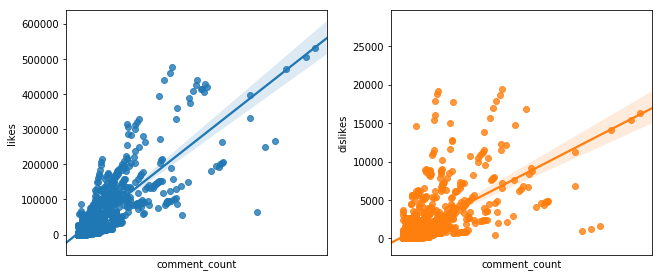

In [103]:
fig, ax = plt.subplots(1, 2, sharex=True)
fig.tight_layout()
plt.subplots_adjust(left=-0.4)
lplot = sns.regplot(data=tidy, x='comment_count', y='likes', ax=ax[0])
lplot.set(xticks=[])
lplot2 = sns.regplot(data=tidy, x='comment_count', y='dislikes', ax=ax[1])
lplot2.set(xticks=[])

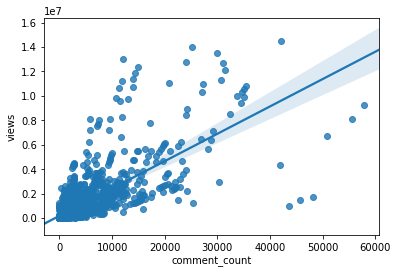

In [92]:
sns.regplot(data=tidy, x='comment_count', y='views')

Now the data looks better without the outliers

In [93]:
tidy.to_csv('tidy_usvideos.csv')

### Let's analyze the video categories

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

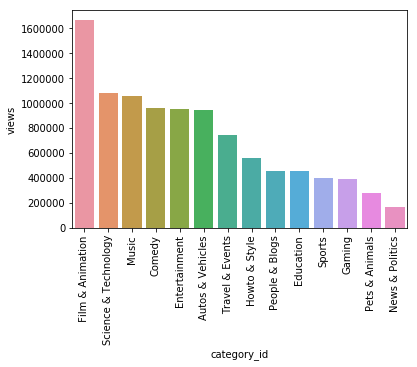

In [94]:
byviews = tidy.groupby('category_id').mean().reset_index().sort_values('views', ascending=False)
sns.barplot(data=byviews, x='category_id', y='views', ci=None)
plt.xticks(rotation=90)

Seems like film & animation, music, and science and technology get the most views, while politics and news get the least. We can get the same plots for likes and dislikes for each category.

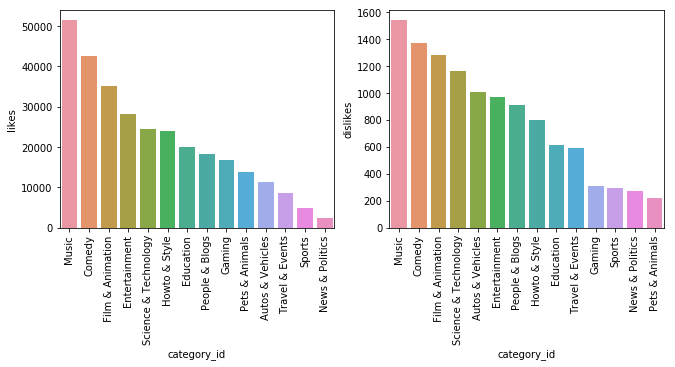

In [113]:
figs, ax = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(left=-0.5)


bylikes = tidy.groupby('category_id').mean().reset_index().sort_values('likes', ascending=False)
sns.barplot(data=bylikes, x='category_id', y='likes', ci=None, ax=ax[0])
bydislikes = tidy.groupby('category_id').mean().reset_index().sort_values('dislikes', ascending=False)
sns.barplot(data=bydislikes, x='category_id', y='dislikes', ci=None, ax=ax[1])

for axes in figs.axes:
    plt.sca(axes)
    plt.xticks(rotation=90)

Let's get a sense of what time did the users like tp uoload their videos.

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

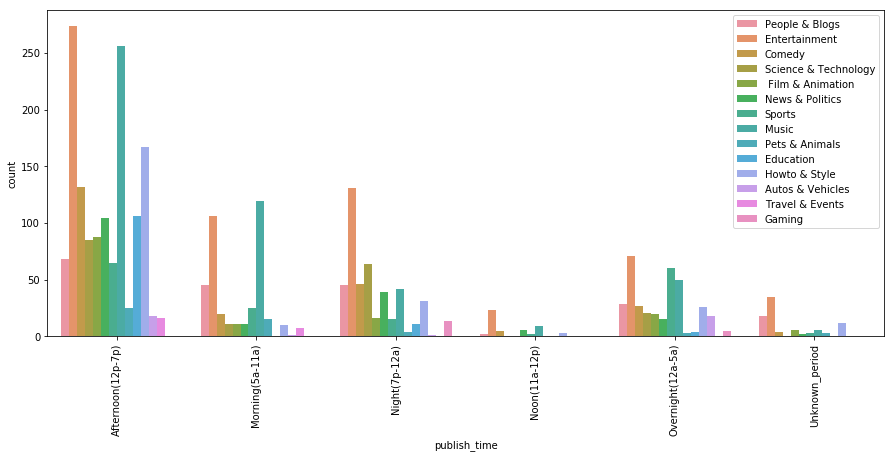

In [96]:
plt.figure(figsize=(15, 6))
sns.countplot(x='publish_time', data=tidy, hue='category_id')
plt.legend(loc='upper right')
plt.xticks(rotation=90)

## Conclusion for video category analysis

So far we have seen that uploading videos in the afternoon seems to be a common feature of trending videos. The most viewed topics are Film & animations, Music, Comedy, Entertainment, and Autos & Vehicles are the most viewed and liked. Although they are also the most dislikes, the ration of likes to dislikes is huge.

# Channel Analysis